In [10]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [11]:
def custom_one_hot(x, depth):
    
    n,p = x.shape
    one_hot_x = np.zeros((n, p, depth))
    
    for i in range(n):
        for j in range(p):
            one_hot_x[i,j,x[i,j]] = 1
            
    return one_hot_x

$b(s,\theta)  = mean((p(a_j| \theta))_j)$

In [35]:
class CommNet:
    
    def __init__(self, sess, N, J, embedding_size = 128, lr = 1e-3, training_mode = 'supervised', alpha = 0.03):
        
        self.N = N
        self.J = J
        self.embedding_size = embedding_size
        
        self.build_controler()
        
        self.training_mode = training_mode
        
        if training_mode == 'supervised':
            self.build_supervised()
            with tf.variable_scope('Supervised_optimizer'):
                self.train_op = tf.train.AdamOptimizer(lr).minimize(self.supervised_loss)
                
        elif training_mode == 'reinforce':
            self.alpha = 0.03
            self.build_reinforce()
            with tf.variable_scope('Reinforce_optimizer'):
                self.train_op =  tf.train.RMSPropOptimizer(lr).minimize(self.reinforce_loss)
            
        else:
            raise(ValueError("Unknown training mode: %s" % training_mode))
        
        print("All variables")
        for var in tf.global_variables():
            print(var)
            
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
        
    def encode(self, inputs):
        
        with tf.variable_scope('Encoder'):
        
            identity_embeddings = tf.get_variable("identity_embeddings",
                                             [self.N, self.embedding_size])
            
            embedded_identities = tf.nn.embedding_lookup(identity_embeddings, inputs)
            
        return tf.unstack(embedded_identities, axis = 1)
    
    def build_f(self, name, h, c, h0 = None):
        
        with tf.variable_scope(name, reuse = tf.AUTO_REUSE):
            
            if h0 is not None:
                
                W1 = tf.get_variable('W1', shape = (3 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c, h0], axis = 1)
            
            else:
                W1 = tf.get_variable('W1', shape = (2 * self.embedding_size,
                                                  self.embedding_size))
                
                concat = tf.concat([h, c], axis = 1)
            
            W2 = tf.get_variable('W2', shape = (self.embedding_size,
                                                  self.embedding_size))
            
            dense1 =  tf.nn.relu(tf.einsum("ij,jk->ik", concat, W1))
            dense2 = tf.nn.relu(tf.einsum("ij,jk->ik", dense1, W2))
            
            return dense2
        
    def decode(self, h):
        
        with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
            
            W = tf.get_variable('W', shape = (self.embedding_size,
                                                  self.J))
            
            policy_logit = tf.einsum("ij,jk->ik", h, W)
        
            return policy_logit
    
    
    def communicate(self, h_seq):
        
        return tf.add_n(h_seq) / (self.J - 1)
    
    def sample_actions(self, policy_logit):
        
        
        action = tf.multinomial(policy_logit, num_samples = 1)
        
        return action
    
        
    def build_controler(self):
        
        self.inputs = tf.placeholder(tf.int32, shape = (None, self.J))
        
        h0_seq = self.encode(self.inputs)
        c0_seq = [self.communicate([h0_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h1_seq = [self.build_f("Comm_step_1", h0_seq[j], c0_seq[j], None) for j in range(self.J)]
        c1_seq = [self.communicate([h1_seq[j] for j in range(self.J) if j != i]) for i in range(self.J)]
        
        h2_seq = [self.build_f("Comm_step_2", h1_seq[j], c1_seq[j], h0_seq[j]) for j in range(self.J)]
        
        
        self.policy_logit_seq = [self.decode(h2) for h2 in h2_seq]
        
        self.proba_seq = [tf.nn.softmax(policy_logit, axis = 1) for policy_logit in self.policy_logit_seq]
        
        self.action_seq = [self.sample_actions(policy_logit) for policy_logit in self.policy_logit_seq]
        
        self.one_hot_action_seq = [tf.one_hot(action, depth = self.J) for action in self.action_seq]
        
        
        
    def build_supervised(self):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        self.targets = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_targets = tf.unstack(self.targets, axis = 1)
        
        supervised_loss_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_targets[j],
                                                                                   logits=self.policy_logit_seq[j])
                                    for j in range(self.J)]
        
        self.supervised_loss = tf.reduce_sum(tf.add_n(supervised_loss_seq))
        
        
        
    def supervised_train(self, X, y, val_X, val_y, env, batch_size = 32, epochs = 1):
        
        assert self.training_mode == 'supervised', 'Wrong training mode'
        
        n = X.shape[0]
        
        val_n = val_X.shape[0]
        
        data_inds = np.array(range(n))
        for ep in range(1, epochs + 1):
            np.random.shuffle(data_inds)
            supervised_loss_sum = 0
            reward_sum = 0
            for i in tqdm(range(0, n, batch_size), "Epoch: %d" % ep):
                inds_batch = data_inds[i:i+batch_size]
                X_batch = X[inds_batch]
                y_batch = y[inds_batch]
                _, supervised_loss, one_hot_action_seq = sess.run([self.train_op, self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: X_batch, self.targets: y_batch})
                supervised_loss_sum += supervised_loss
                reward_sum += env.get_reward(one_hot_action_seq)
            
            print("loss = %f" % (supervised_loss_sum / n))
            print("reward = %f" % (reward_sum / n))
            print()
            
            val_supervised_loss, val_one_hot_action_seq = sess.run([self.supervised_loss, self.one_hot_action_seq], feed_dict={self.inputs: val_X, self.targets: val_y})
            print('val loss = %f' % (val_supervised_loss / val_n))
            print('val reward = %f' % (env.get_reward(val_one_hot_action_seq) / val_n))
            

    def build_reinforce(self):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        self.reward_values = tf.placeholder(tf.float32, shape = (None,))
        reverse_cum_sum_reward_values = tf.cumsum(self.reward_values, reverse = True)
        
        self.baseline_weights = tf.placeholder(tf.float32, shape = (None,))
        self.advantage_values = tf.placeholder(tf.float32, shape = (None,))
  
        
        self.action_taken = tf.placeholder(tf.int32, shape = (None, self.J))
        unstacked_action_taken = tf.unstack(self.action_taken, axis = 1)
        one_hot_action_taken_seq = [tf.one_hot(action, depth = self.J, dtype = tf.int32) for action in unstacked_action_taken]
        
        self.neg_log_p_seq = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=unstacked_action_taken[j],
                                                    logits=self.policy_logit_seq[j]) for j in range(self.J)]
        
        neg_log_p_sums = tf.reduce_sum(self.neg_log_p_seq, axis = 0)
        
        self.proba_action_taken = tf.concat([[tf.dynamic_partition(self.proba_seq[j], one_hot_action_taken_seq[j], num_partitions = 2)[1] for j in range(self.J)]], axis = 0)
        baselines = tf.reduce_prod(self.proba_action_taken, axis = 0)
        
        #surrogate loss (- dtheta)
        
        advantage = reverse_cum_sum_reward_values - tf.multiply(self.baseline_weights, baselines)
        
        self.reinforce_loss =  tf.multiply(neg_log_p_sums, self.advantage_values)
        #self.reinforce_loss += self.alpha * tf.square(advantage)
        self.reinforce_loss = tf.reduce_sum(self.reinforce_loss, axis = 0)
        
        
    def take_action(self, state):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        action_seq, proba_seq = self.sess.run([self.action_seq, self.proba_seq], {self.inputs: [state]})
        
        return [a[0,0] for a in action_seq], proba_seq
    
    def reinforce_train(self, env, n_episodes, T):
        
        assert self.training_mode == 'reinforce', 'Wrong training mode'
        
        
        history = {'reward' : [],  'loss': []}
    
        
        for _ in tqdm(range(n_episodes), "REINFORCE"):
            
            # todo: change code to avoid this seq_seq name (sequence of sequence)
            state_seq, action_seq, reward_seq, proba_seq = policy_rollout(T, env, commNet)
            episode_lenght = reward_seq.shape[0]
            
            one_hot_action_seq = custom_one_hot(action_seq, self.J)
            
            history['reward'].append(np.mean(reward_seq))
            
            baseline = proba_seq[np.where(one_hot_action_seq)].reshape(episode_lenght, self.J).prod(axis = 1)
            reward_sum_values = np.array([reward_seq[t:].sum() for t in range(episode_lenght)])
            
            baseline_weights = [(episode_lenght - t) for t in range(episode_lenght)]
            
            advantage_values = np.array([reward_sum_values[t] - baseline_weights[t] * baseline[t] for t in range(episode_lenght)])
            
            
            feed_dict = {}
            feed_dict[self.inputs] = state_seq
            feed_dict[self.reward_values] = reward_seq
            feed_dict[self.baseline_weights] = baseline_weights
            feed_dict[self.advantage_values] = advantage_values
            feed_dict[self.action_taken] = action_seq
            
            _, loss = self.sess.run([self.train_op, self.reinforce_loss], feed_dict = feed_dict)
            
            history['loss'].append(loss)
            
        return history
            
            
            
            
            
            
            
        

In [36]:
class LeverEnv:
    
    def __init__(self, N, J):
        
        self.J = J
        self.N = N
        
    def reset(self):
        
        state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        terminal_state = False
        
        return state, terminal_state        
    
    def get_reward(self, one_hot_action_seq):        
        
        reward = np.sum(np.sum(one_hot_action_seq, axis = 0) > 0) /self.J
        
        return reward
        
    def step(self, state, action):
        
        next_state = np.sort(np.random.choice(self.N, size = self.J, replace = False))
        
        one_hot_action_seq = np.zeros((self.J, self.J))
        one_hot_action_seq[range(self.J), action] = 1
        reward = self.get_reward(one_hot_action_seq)
        
        terminal_state = False
        
        return next_state, reward, terminal_state
        

In [37]:
# data generation for supervised learning
def generate_data(n, N, J):
    
    X = np.empty((n, J), dtype = int)
    
    for i in range(n):
        
        X[i] = np.sort(np.random.choice(N, size = J, replace = False))
        
    y = np.tile([j for j in range(J)], (n,1))
        
    return X, y

In [38]:
# episode generation for reinforcement learning
def policy_rollout(T, env, agent):
    
    state_seq = []
    action_seq = []
    reward_seq = []
    proba_seq = []
    
    
    state, terminal_state = env.reset()
    
    t = 0
    
    while not terminal_state and t < T:
        t +=1
        
        state_seq.append(state)
        action, proba = agent.take_action(state)
        
        state, reward, terminal_state = env.step(state, action)
        
        
        action_seq.append(action)
        reward_seq.append(reward)
        proba_seq.append(proba)
        
    return np.array(state_seq), np.array(action_seq), np.array(reward_seq), np.squeeze(np.array(proba_seq))

In [39]:
N = 20
J = 4
batch_size = 64
n = batch_size * 50000

In [40]:
#X, y = generate_data(n, N, J)
#val_X, val_y = generate_data(1024, N, J)

In [43]:
tf.reset_default_graph()
with tf.Session() as sess:
    commNet = CommNet(sess, N, J, lr = 1e-3, training_mode = 'reinforce')
    env = LeverEnv(N, J)
    #commNet.supervised_train(X, y, val_X, val_y, env, batch_size = batch_size, epochs = 10)
    
    history = commNet.reinforce_train(env, n_episodes = 10000, T = 10)


All variables
<tf.Variable 'Encoder/identity_embeddings:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_1/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W1:0' shape=(384, 128) dtype=float32_ref>
<tf.Variable 'Comm_step_2/W2:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Decoder/W:0' shape=(128, 4) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/RMSProp:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Encoder/identity_embeddings/RMSProp_1:0' shape=(20, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/RMSProp:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W1/RMSProp_1:0' shape=(256, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W2/RMSProp:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Reinforce_optimizer/Comm_step_1/W2/RMSProp_1:0' sha

REINFORCE: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [01:32<00:00, 54.04it/s]


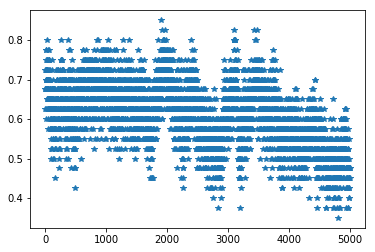

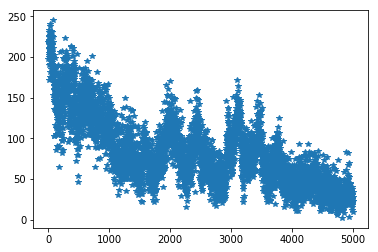

In [44]:
plt.plot(history['reward'], '*')
plt.show()
plt.plot(history['loss'], '*')
plt.show()

In [87]:
rv[0]

[array([[ 0.0596518 ,  0.02269639, -0.07532956, -0.07540955, -0.08110422],
        [ 0.5630493 ,  0.5918072 , -0.10008261, -0.7850738 , -0.05149139],
        [ 0.16138737,  0.63799644,  0.1940138 , -0.53420883, -0.36678162]],
       dtype=float32),
 array([[-0.03205522,  0.12239126,  0.07110118, -0.07921434, -0.01101556],
        [ 0.07625176,  0.04617479, -0.07478796, -0.08644816, -0.08472059],
        [ 0.04974654,  0.02406349, -0.0529843 , -0.06999239, -0.07339071]],
       dtype=float32),
 array([[-0.07162067,  0.2199525 ,  0.12068282, -0.10001396,  0.00314371],
        [-0.17366661,  0.02431826,  1.0898598 , -0.39155653, -0.35307264],
        [-0.01440799, -0.05208569, -0.04038611, -0.12251391,  0.27661273]],
       dtype=float32),
 array([[ 0.30248976,  0.35904372,  0.13852054, -0.44916093, -0.10978251],
        [-0.06447662,  0.2655132 ,  0.14209045, -0.12286793, -0.01895462],
        [-0.02358865,  0.24085267,  0.24232423, -0.33448112,  0.02199232]],
       dtype=float32),
 arr

In [33]:
rv[1]

[array([1.679203 , 1.6416962, 1.759013 ], dtype=float32),
 array([1.5444648, 1.6245147, 1.5454775], dtype=float32),
 array([1.6385748, 1.608356 , 1.6981841], dtype=float32),
 array([1.4584316, 1.5151768, 1.608307 ], dtype=float32),
 array([1.618038 , 1.7417368, 1.5020348], dtype=float32)]

In [34]:
rv[2]

17.933714

In [35]:
rv[3]

[array([[0.22021596, 0.20301364, 0.1928451 , 0.1974027 , 0.18652259],
        [0.23498784, 0.19094285, 0.1936513 , 0.1955532 , 0.1848648 ],
        [0.22991428, 0.20183986, 0.19005087, 0.20598018, 0.17221476]],
       dtype=float32),
 array([[0.2138513 , 0.18584296, 0.20003676, 0.21342605, 0.18684298],
        [0.2087248 , 0.19814251, 0.19700727, 0.21293077, 0.18319465],
        [0.21321003, 0.1978885 , 0.21177672, 0.19580315, 0.18132162]],
       dtype=float32),
 array([[0.22752823, 0.18751231, 0.19153218, 0.1942567 , 0.19917065],
        [0.22342516, 0.20021649, 0.19006218, 0.19727759, 0.18901852],
        [0.2210608 , 0.18301556, 0.19006892, 0.21101694, 0.19483787]],
       dtype=float32),
 array([[0.23260082, 0.20193927, 0.1894041 , 0.19137487, 0.18468103],
        [0.21027339, 0.19868067, 0.21976934, 0.1951085 , 0.17616804],
        [0.22195815, 0.19344223, 0.2002263 , 0.2077131 , 0.17666027]],
       dtype=float32),
 array([[0.21078177, 0.18585777, 0.19828734, 0.21378818, 0.19128

In [310]:
[[2 2 3 3 4]
 [2 1 1 2 0]
 [1 0 4 0 0]]

SyntaxError: invalid syntax (<ipython-input-310-262fc6ab6e89>, line 1)

In [308]:
rv[4]

[array([0.18897834, 0.19655573, 0.2020707 ], dtype=float32),
 array([0.19602942, 0.19807835, 0.19110735], dtype=float32),
 array([0.20443515, 0.194682  , 0.20374517], dtype=float32),
 array([0.20015913, 0.20955497, 0.19200996], dtype=float32),
 array([0.20433995, 0.1863594 , 0.19333121], dtype=float32)]

In [341]:
with tf.Session() as sess:
    
    x = [[[0,1,2]], [[0,2,3]]]
    c = tf.concat(x, axis = 0)
    
    cv = sess.run(c)
cv

array([[0, 1, 2],
       [0, 2, 3]])

In [311]:
action_seq

array([[2, 2, 3, 3, 4],
       [2, 1, 1, 2, 0],
       [1, 0, 4, 0, 0]], dtype=int64)

In [333]:
custom_one_hot(action_seq, 5).astype(int)

array([[[0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]],

       [[0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]]])

In [332]:
np.where(custom_one_hot(action_seq, 5).astype(int))

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int64),
 array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4], dtype=int64),
 array([2, 2, 3, 3, 4, 2, 1, 1, 2, 0, 1, 0, 4, 0, 0], dtype=int64))

In [334]:
proba_seq[np.where(custom_one_hot(action_seq, 5).astype(int))]

array([0.18897833, 0.19602942, 0.20443515, 0.20015912, 0.20433994,
       0.19655573, 0.19807835, 0.19468199, 0.20955497, 0.18635936,
       0.2020707 , 0.19110735, 0.20374517, 0.19200996, 0.19333121],
      dtype=float32)

In [335]:
proba_seq[np.where(custom_one_hot(action_seq, 5).astype(int))].reshape(3,5)

array([[0.18897833, 0.19602942, 0.20443515, 0.20015912, 0.20433994],
       [0.19655573, 0.19807835, 0.19468199, 0.20955497, 0.18635936],
       [0.2020707 , 0.19110735, 0.20374517, 0.19200996, 0.19333121]],
      dtype=float32)